# IN3061/INM430 - Tiny DS Project Progress Report


***

** Student Name: ** <b>Prapas Rakchartkiattikul<b>

** Project Title:** <b>Insight and factors that make Kickstarter project successful <b>

***




Import neccessary libraries and created helper functions to help in analysis

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import urllib.parse 
import matplotlib.pyplot as plt
import copy 
import json
import statsmodels.api as sm
from scipy import stats
pd.set_option('display.max_columns', None)

In [2]:
# Define Helper Funcitons
# Get category from url function

def get_category(str_dict):
    dictionary = json.loads(str_dict)
    url = dictionary['urls']['web']['discover']
    parse_result = urllib.parse.urlsplit(url)
    url_path = parse_result.path
    sub_string = url_path.split('/')
    if len(sub_string) == 4:
        return sub_string[-1]
    else:
        return sub_string[-2]


#https://stackoverflow.com/questions/38354383/finding-substring-in-list-of-strings-return-index
def get_index(list_of_strings, substring):
    try:
        return next(i for i, e in enumerate(list_of_strings) if substring in e)
    except StopIteration:
        return len(list_of_strings) - 1


#https://www.geeksforgeeks.org/python-convert-string-dictionary-to-dictionary/
def get_value_dict(str_dict,val):
    try:
        dictionary = json.loads(str_dict)
        value = dictionary[val]
    except:
        temp = str_dict.split(",")
        idx = get_index(temp,val)
        temp2 = temp[idx].split(":")
        value = temp2[1]
    return value

## A.Data Preparation

The dataset used in this analysis is the projects' information in the Kickstarter from 2009 -2019. The data has been scraped from Kickstarter website by webrobots.io  every month from 2018-2019. Upon conducting the data check, the data file shows some inconsistent behavior, i.e., some of the projects in the 2018 file do not appear in 2019. In order to have a complete set of project, all the files were read in, checked for duplication, and kept only the latest status. The duplication is checked by the uniqueness of the project ID

In [3]:
#Get data location path
cwd = os.getcwd()
script_path = cwd + '/'
data_path = script_path + 'Data'

In [4]:
# Extracrt the list of folder
folder=[]
folder = [f for f in sorted(os.listdir(data_path))]
try:
    folder.remove('.DS_Store')
except:
    pass

In [5]:
folder

['2018-01-12',
 '2018-02-12',
 '2018-03-15',
 '2018-09-13',
 '2018-10-18',
 '2018-11-15',
 '2018-12-13',
 '2019-01-17',
 '2019-02-14',
 '2019-03-14',
 '2019-04-18',
 '2019-05-16',
 '2019-06-13',
 '2019-07-18',
 '2019-08-15',
 '2019-09-12',
 '2019-10-17',
 '2019-11-14',
 '2019-12-12']

In [6]:
# For each folder in the data path (Try 2018)
counter = 0
for i in folder:
    folder_path = data_path + '/' +i
    files = []
    files = [f for f in sorted(os.listdir(folder_path))] 
    try:
        files.remove('.DS_Store')
    except:
        pass
    # For each file in each folder
    for x in files:
        file_path =  folder_path + '/' + x
        df_temp = pd.read_csv(file_path)
        df_temp['file_name'] = pd.to_datetime(i, format='%Y/%m/%d')

        if counter ==0:#First time that run the code
            df_temp2 = pd.DataFrame()
            df_prj = pd.concat([df_temp2,df_temp])
        else:
            df_prj = pd.concat([df_prj,df_temp],ignore_index = True)
        counter+=1
    #Remove duplciate
    df_prj = df_prj.sort_values('file_name').drop_duplicates('id',keep='last')
    print('The data file that scraped on', i, 'has been successfuly read in and removed the duplication')
    print('The amount of observation is',len(df_prj))

# For reservation
df_clone = copy.deepcopy(df_prj)

The data file that scraped on 2018-01-12 has been successfuly read in and removed the duplication
The amount of observation is 178458
The data file that scraped on 2018-02-12 has been successfuly read in and removed the duplication
The amount of observation is 182420
The data file that scraped on 2018-03-15 has been successfuly read in and removed the duplication
The amount of observation is 185694
The data file that scraped on 2018-09-13 has been successfuly read in and removed the duplication
The amount of observation is 196781
The data file that scraped on 2018-10-18 has been successfuly read in and removed the duplication
The amount of observation is 200674
The data file that scraped on 2018-11-15 has been successfuly read in and removed the duplication
The amount of observation is 204060
The data file that scraped on 2018-12-13 has been successfuly read in and removed the duplication
The amount of observation is 206761
The data file that scraped on 2019-01-17 has been successfuly 

Various attributes also collected in an unready to use format. For example, the value of 'category' and 'creator' attributes need to be extracted from the dictionary format. Also, the timestamp value is converted to UTC from UNIX format


In [8]:
df_prj['category'] = df_prj['category'].apply(get_category)
df_prj['category']= df_prj.category.str.replace('%20', ' ')

In [9]:
# Convert unix time to date. The converted time is in UTC.
# https://stackoverflow.com/questions/49949244/convert-unix-epoch-time-to-datetime-in-pandas
date_col = ['created_at','deadline','launched_at','state_changed_at']

from datetime import datetime, timedelta
start = datetime(1970, 1, 1)  # Unix epoch start time

for i in date_col:
    df_prj[i] = df_prj[i].apply(lambda x: start + timedelta(seconds=x))
    df_prj[i]=  pd.to_datetime(df_prj[i],format='%Y-%m-%d %H:%M:%S')

The project’s state other than' successful’ and ‘failed’ was also removed from the dataset since it is not in the analysis scope.

In [10]:
print('The state in the original dataset consist of', set(df_prj['state'].to_list()))

The state in the original dataset consist of {'live', 'successful', 'suspended', 'canceled', 'failed'}


In [11]:
#Change success to 1 and failed to 0
df_prj = df_prj[(df_prj['state'] == 'successful')|(df_prj['state'] == 'failed')]
df_prj['state'] = df_prj['state'].map({'successful': 1, 'failed': 0})

In [12]:
print('The amount of observation is',len(df_prj))

The amount of observation is 238098


A check point to recheck that the dataset has no duplication

In [13]:
dups = df_prj.pivot_table(index = ['id'], aggfunc ='size') 
sum(dups) ==len(df_prj)

True

Other data prepocessed also perform to change the datatype and fill in the na values

In [14]:
# Rearrangr the columns
df_kickstarter =  copy.deepcopy(df_prj[['id', 'name','slug', 'blurb', 'category' ,'creator', 
                         'country', 'country_displayable_name', 'photo', 'profile', 'created_at', 
                         'launched_at', 'deadline', 'state', 'state_changed_at','backers_count', 
                         'pledged', 'goal', 'currency', 'currency_symbol', 'currency_trailing_code', 
                         'fx_rate', 'current_currency', 'converted_pledged_amount', 'spotlight', 'staff_pick',
                         'static_usd_rate', 'urls', 'usd_pledged', 'usd_type', 'location', 'disable_communication',
                         'friends', 'is_backing', 'is_starred', 'permissions', 'file_name', 'unread_messages_count',
                         'unseen_activity_count', 'is_starrable', 'source_url']])
df_kickstarter.reset_index(inplace = True)

In [15]:
#Extract creator
df_kickstarter['creator_id'] = df_kickstarter['creator'].apply(get_value_dict,args =['id'])
df_kickstarter['creator_id'] =df_kickstarter['creator_id'].astype(int)

In [16]:
#Mapping Name
df_kickstarter['country_displayable_name'] = df_kickstarter['country'].map({'AT':'Australia','AU':'Austria',
                                                           'BE':'Belgium','CA':'Canada','CH':'Switzerland',
                                                           'DE':'Germany','DK':'Denmark','ES':'Spain','FR':'France',
                                                           'GB':'the United Kingdom','HK':'Hong Kong','IE':'Ireland',
                                                           'IT':'Italy','JP':'Japan','LU':'Luxembourg','MX':'Mexico',
                                                           'NL':'the Netherlands','NO':'Norway','NZ':'New Zealand',
                                                           'SE':'Sweden','SG':'Singapore','US':'the United States'})

In [17]:
#Convert from logical to number
df_kickstarter['spotlight'] = np.where(df_kickstarter['spotlight']==True, 1, 0)
df_kickstarter['staff_pick'] = np.where(df_kickstarter['staff_pick']==True, 1, 0)

## B.Data Derivation

Seven features will be derived as an attempt to provide more insight of the successful project<br>
1. pledged_usd =  Project’s pledged value (fund) in USD (To convert monetary value to the same unit)
2. goal_usd = Project’s goal in USD (To convert monetary value to the same unit)
3. avg_pledges_usd = An average pledge value per backer, served as a proxy for an average reward value that backer willing to buy<br>
4. prj_count = A number of past  project created by creator served as a proxy for creator's credibility<br>
5. local_launched_date = The day(Mon, tues,..) at which the project is launched in local time
6. prj_duration = Project Duration<br>
7. %_reached_bin = The bin of ratio between pledged and goal amount 

In [18]:
#1 & 2 Create pledges_usd and goal_usd
df_kickstarter['pledged_usd'] = df_kickstarter['pledged'] * df_kickstarter['fx_rate']
df_kickstarter['goal_usd'] = df_kickstarter['goal'] * df_kickstarter['fx_rate']

In [19]:
drop_col =['index','slug','blurb','photo','creator','profile','currency_symbol','currency_trailing_code',
           'pledged','goal','currency',
           'converted_pledged_amount','static_usd_rate','urls','usd_pledged','usd_type','location','disable_communication',
           'friends','is_backing','is_starred','permissions','usd_pledged',
           'unread_messages_count','unseen_activity_count','is_starrable','fx_rate']
df_kickstarter = df_kickstarter.drop(drop_col, axis = 1) 

In [20]:
# 3. Create abg_pledges_usd
df_kickstarter['avg_pledges_usd'] = np.where(df_kickstarter['backers_count'] == 0, 0, round(df_kickstarter['pledged_usd']/df_kickstarter['backers_count'],2))

In [21]:
#4. Create prj_count
df_kickstarter.sort_values('created_at', inplace =True)
df_kickstarter.reset_index(inplace = True)
df_kickstarter = df_kickstarter.drop('index',axis =1)
df_kickstarter['prj_count'] = df_kickstarter.groupby('creator_id').cumcount() + 1


In [22]:
#5 Create local_launched_date
time_zone_dif = {'AT':7,'AU':1,'BE':1,'CA':-5,'CH':1,
                 'DE':1,'DK':-3,'ES':1,'FR':1,'GB':1,
                 'HK':8,'IE':0,'IT':1,'JP':9,'LU':1,
                 'MX':-6,'NL':1,'NO':1,'NZ':13,'SE':1,
                 'SG':8,'US':-5}

df_kickstarter['time_dif'] = df_kickstarter['country'].map(time_zone_dif)
df_kickstarter['local_launched_time'] = df_kickstarter['launched_at'] + np.array(df_kickstarter['time_dif'] ,dtype='timedelta64[h]')
df_kickstarter['local_launched_date'] = df_kickstarter['local_launched_time'].dt.strftime('%A')



# Change datetime to date

for i in date_col:
    df_kickstarter[i] = df_kickstarter[i].dt.date
    
df_kickstarter = df_kickstarter.drop('time_dif',axis =1)
df_kickstarter = df_kickstarter.drop('local_launched_time',axis =1)

In [23]:
# 6. Create Project Duration
df_kickstarter['prj_duration']= df_kickstarter['deadline']-df_kickstarter['launched_at']
df_kickstarter['prj_duration'] = df_kickstarter['prj_duration'].dt.days

In [24]:
# 7. Create %_reach_bin
df_kickstarter['%_reached']= round(df_kickstarter['pledged_usd']/df_kickstarter['goal_usd'],2)
df_kickstarter['%_reached_bins'] = pd.cut(df_kickstarter['%_reached'], bins=[0, 0.2, 0.4, 0.6,0.8, 1,1.2,1.4,1.6,1.8,2,float("inf")],include_lowest =True)


In [25]:
df_kickstarter.head()

,id,name,category,country,country_displayable_name,created_at,launched_at,deadline,state,state_changed_at,backers_count,current_currency,spotlight,staff_pick,file_name,source_url,creator_id,pledged_usd,goal_usd,avg_pledges_usd,prj_count,local_launched_date,prj_duration,%_reached,%_reached_bins
0,1473103893,TELEVISION LANDSCAPE: Making the Record.,music,US,the United States,2009-04-21,2009-06-19,2009-09-15,1,2009-09-15,33,USD,1,0,2018-12-13,https://www.kickstarter.com/discover/categorie...,1505954783,2000.0,2000.0,60.61,1,Thursday,88,1.00,"(0.8, 1.0]"
1,405307432,Electronola - An electronic gumbo of New Orlea...,music,US,the United States,2009-04-22,2009-05-01,2009-06-05,1,2009-06-05,114,USD,1,1,2019-12-12,https://www.kickstarter.com/discover/categorie...,11,4100.6,4000.0,35.97,1,Friday,35,1.03,"(1.0, 1.2]"
2,139963887,How to Build a City in 200 Days: Mahabalipuram...,journalism,US,the United States,2009-04-23,2009-11-19,2010-01-18,1,2010-01-18,60,USD,1,0,2019-12-12,https://www.kickstarter.com/discover/categorie...,1782188740,3425.0,3000.0,57.08,1,Thursday,60,1.14,"(1.0, 1.2]"
3,1672335313,My Teenage Stride New Album,music,US,the United States,2009-04-23,2010-01-05,2010-02-24,1,2010-02-24,55,USD,1,1,2018-12-13,https://www.kickstarter.com/discover/categorie...,1309681027,2450.0,2300.0,44.55,1,Tuesday,50,1.07,"(1.0, 1.2]"
4,1304906577,Accidental to Edinburgh - PHASE 1: AIRFARE,theater,US,the United States,2009-04-24,2009-04-30,2009-06-05,1,2009-06-05,24,USD,1,1,2018-12-13,https://www.kickstarter.com/discover/categorie...,1802123423,6575.0,6000.0,273.96,1,Thursday,36,1.10,"(1.0, 1.2]"


<b> The below section is another step to perform data preprocesssing after we derived all the attributed and removed all the unnecessary variables

The dataset is later checked for the abnormality in the data such as being successful but %_reached is less than 1 and vice versa

In [26]:
ab1 = (df_kickstarter['state'] == 1) & (df_kickstarter['%_reached'] <1)
df_kickstarter = df_kickstarter[~ab1]
ab2 = (df_kickstarter['state'] == 0) & (df_kickstarter['%_reached'] >=1)
df_kickstarter = df_kickstarter[~ab2]
df_kickstarter.reset_index(inplace = True)
df_kickstarter = df_kickstarter.drop('index',axis =1)

Checking for null data

In [27]:
#Check Null:
df_kickstarter.isna().sum()

id                          0
name                        1
category                    0
country                     0
country_displayable_name    0
created_at                  0
launched_at                 0
deadline                    0
state                       0
state_changed_at            0
backers_count               0
current_currency            0
spotlight                   0
staff_pick                  0
file_name                   0
source_url                  0
creator_id                  0
pledged_usd                 0
goal_usd                    0
avg_pledges_usd             0
prj_count                   0
local_launched_date         0
prj_duration                0
%_reached                   0
%_reached_bins              0
dtype: int64

The data is completed, there's small null data in name, which is just a description of the project id so it is ignorable

Next, we are moving ot check the distribution of the data as an attempt to detect extreme outlier

In [28]:
cont_pred = ['goal_usd','avg_pledges_usd','prj_count','prj_duration']
bool_pred = ['staff_pick','spotlight']
cat_pred = ['local_launched_date']

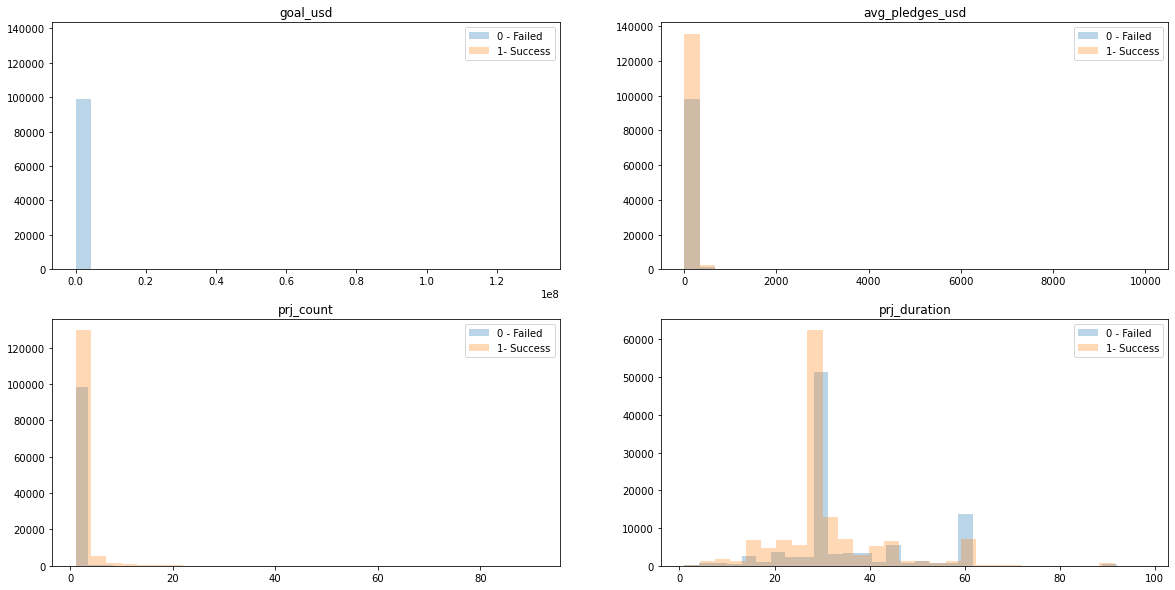

In [29]:
nrow = 2
ncol =2
i=0

fig, axes = plt.subplots (nrow,ncol,figsize=(20,10))
for row in range(nrow):
    for col in range(ncol):
        if i < len(cont_pred):
            #plt.hist(df_success[df_success['category'] == 'art']['goal_usd'])
            #arr = df_kickstarter_rmv[df_kickstarter_rmv['category'] == high_cat[i]][ind_var[j]]
            #axes[i,j].hist(arr)
            axes[row,col].hist(df_kickstarter[df_kickstarter['state']==0][cont_pred[i]],bins=30,alpha= 0.3)
            axes[row,col].hist(df_kickstarter[df_kickstarter['state']==1][cont_pred[i]],bins=30,alpha= 0.3)
            axes[row,col].title.set_text(cont_pred[i])
            axes[row,col].legend(('0 - Failed','1- Success'))
            i+=1
    

It can be seen that all the continuous attributes except for 'prj_duration' is right skewed since it has no negative value (right skewed by nature). <br>
What interesting here is the distribution of 'goal_usd'. It can be seen that the width of the successful projects is very slim compared to that of the failed project.


Let's plot the scatter chart to see the distribution in details

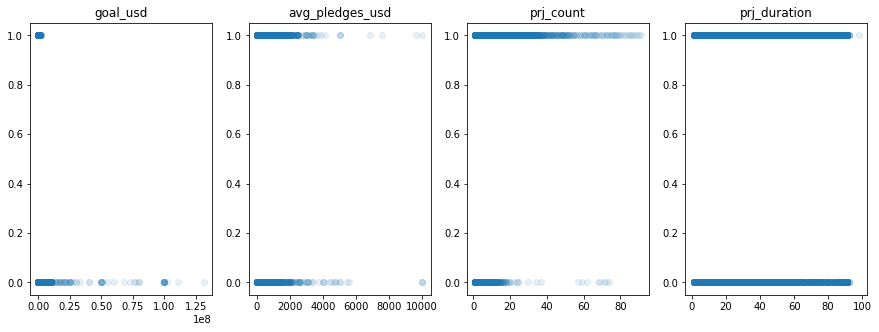

In [30]:
nrow = 1
ncol =4
i=0

fig, axes = plt.subplots (nrow,ncol,figsize=(15,5))
for row in range(nrow):
    for col in range(ncol):
        if i < len(cont_pred):
            axes[col].scatter(df_kickstarter[cont_pred[i]],df_kickstarter['state'], alpha=0.1)
            axes[col].title.set_text(cont_pred[i])
            i+=1
    

From the scatter plot, it seems to be few extreme outlier in 'goal_usd' and 'avg_pedges_usd' since there are few observations that falls in the upper boudary.<br>
Since the data is right skewed by nature, only the data that exceed 'Quartile 3 +1.5IQR' will be removed.

In [31]:
#Remove the outlier
#Remove Outlier
q1 = df_kickstarter.quantile(.25)
q3 = df_kickstarter.quantile(.75)
iqr = q3 - q1
max_limit = q3  + 1.5*iqr

#Remove Oulier
df_kickstarter['notOutlier'] = (df_kickstarter['goal_usd']<=max_limit['goal_usd']) & (df_kickstarter['avg_pledges_usd']<=max_limit['avg_pledges_usd']) 
df_kickstarter = df_kickstarter[(df_kickstarter['notOutlier'] == True)]



In [32]:
print('The amount of observation is',len(df_kickstarter))

The amount of observation is 198128


Recheck the histogram distribution again

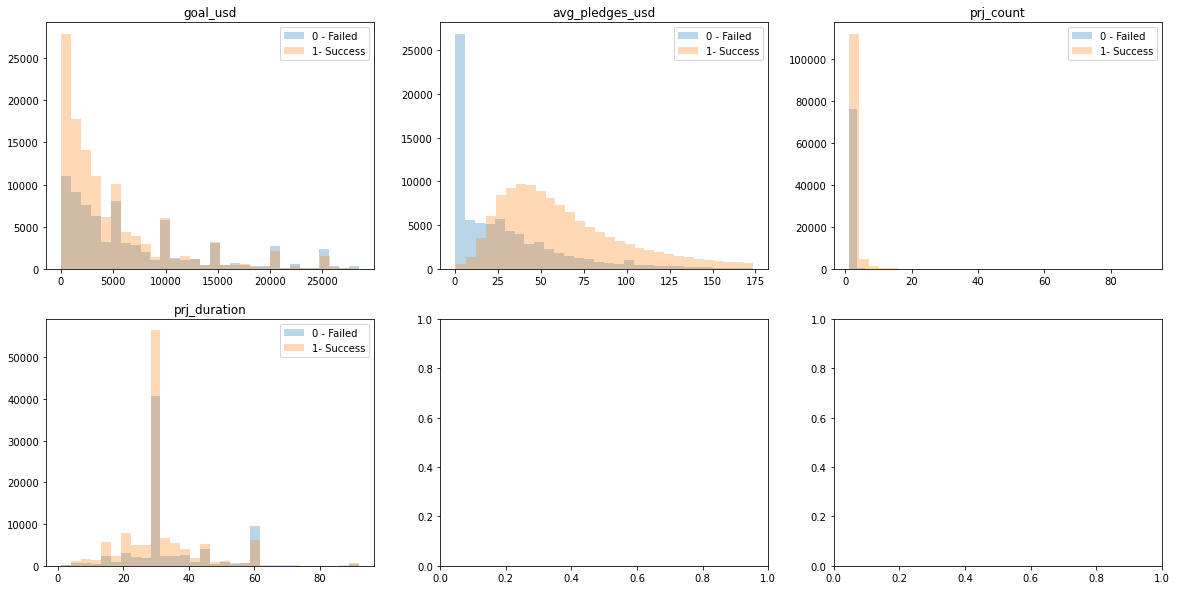

In [33]:
nrow = 2
ncol =3
i=0

fig, axes = plt.subplots (nrow,ncol,figsize=(20,10))
for row in range(nrow):
    for col in range(ncol):
        if i < len(cont_pred):
            #plt.hist(df_success[df_success['category'] == 'art']['goal_usd'])
            #arr = df_kickstarter_rmv[df_kickstarter_rmv['category'] == high_cat[i]][ind_var[j]]
            #axes[i,j].hist(arr)
            axes[row,col].hist(df_kickstarter[df_kickstarter['state']==0][cont_pred[i]],bins=30,alpha= 0.3)
            axes[row,col].hist(df_kickstarter[df_kickstarter['state']==1][cont_pred[i]],bins=30,alpha= 0.3)
            axes[row,col].title.set_text(cont_pred[i])
            axes[row,col].legend(('0 - Failed','1- Success'))
            i+=1
    

It can be seen that the data is less skewed after we remove the extreme outlier

These seven attributes along with ‘category’, ’country’, ‘staff_pick’, and ‘state’ attributes in the original data, are used in the further analysis.

## C.Construction of Models

### What is the landscape and trend of the Kickstarter platform?

The approach to answering the first analytical question is by the mean of visual analytic

In [34]:
print('Basic characteristic of the dataset')
print('There are a total of', len(df_kickstarter), 'projects from',pd.DatetimeIndex(df_kickstarter['launched_at']).year.min(),'to',pd.DatetimeIndex(df_kickstarter['launched_at']).year.max())
print('There are', len(df_kickstarter[df_kickstarter['state']==1]),'successful projects,',round(len(df_kickstarter[df_kickstarter['state']==1])*100/len(df_kickstarter),2),'%')

Basic characteristic of the dataset
There are a total of 198128 projects from 2009 to 2019
There are 120712 successful projects, 60.93 %


To understand Kickstarter’s landscape, it is crucial to see the distribution of each project type and its success rate. 

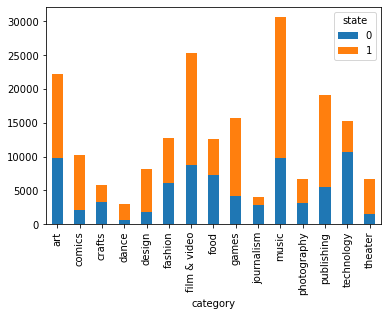

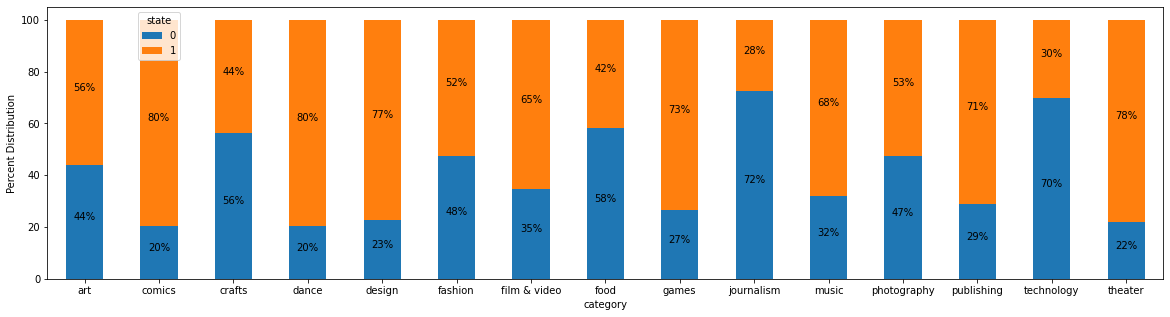

In [35]:
pd.crosstab(df_kickstarter['category'], df_kickstarter['state']).plot(kind='bar', stacked=True)


# https://stackoverflow.com/questions/57981287/display-percent-of-100-in-stacked-bar-plot-from-crosstab-from-matplotlib-in-pand
ax= pd.crosstab(df_kickstarter['category'], df_kickstarter['state']).apply(lambda r: r/r.sum()*100, axis=1)
ax_1 = ax.plot.bar(figsize=(20,5),stacked=True, rot=0)
#display(ax)
plt.legend(loc='upper center', bbox_to_anchor=(0.1, 1.0), title="state")
plt.xlabel('category')
plt.ylabel('Percent Distribution')


for rec in ax_1.patches:
    height = rec.get_height()
    ax_1.text(rec.get_x() + rec.get_width() / 2, 
              rec.get_y() + height / 2,
              "{:.0f}%".format(height),
              ha='center', 
              va='bottom')


plt.show()

From the figure the the top 3 most popular categories are
1. music
2. film & video
3. art

Most of the categories have high achivement rate(exceed 50%) except for 4 categoreis that have sucess rate <50%
1. Craft
2. Food
3. Jounalism
4. Technology 

It can be seen that Kickstarter is very popular for Art-Type projects. This statement is obvious by the various kinds of Art-Type categories such as music, film& video, and design against just three non-Art-Type categories (Food, Games, and Technology). The top 3 categories that have the most project also belong to the Art-Type categories. Most of the categories also have a high success rate (exceed 50%) except for four categories, in which two of them belong to the non-Art-Type project (Food and technology). This information indicates that Kickstarter is popular among the non-Art-Type project. It also suggests that 'category' should affect the success rate of the project.

The next figure is trying to find the trend of each category through time

Text(0.5, 1.0, '3')

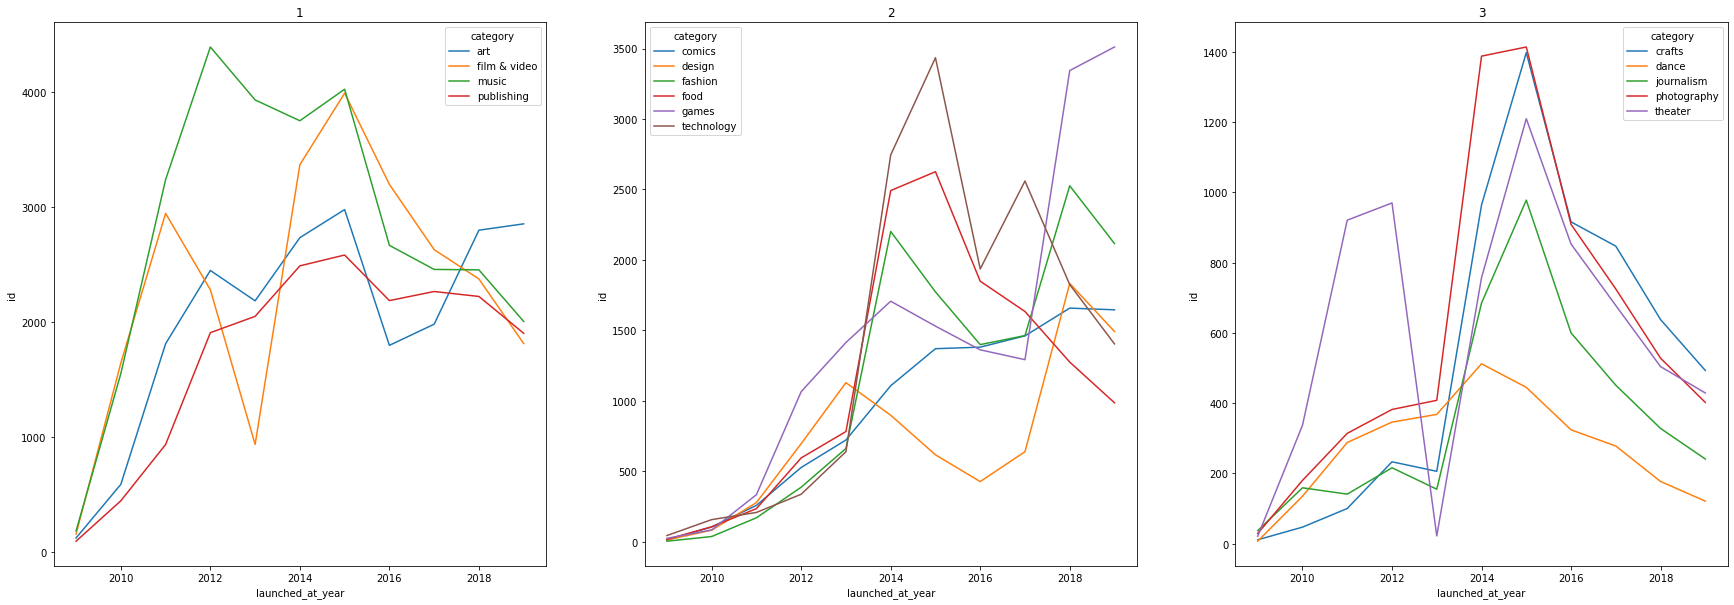

In [36]:
#Create temporary df for calculation
df_kickstarter['launched_at_year'] = pd.DatetimeIndex(df_kickstarter['launched_at']).year
temp =df_kickstarter.groupby(['launched_at_year', 'category'])['id'].count()
df_temp = pd.DataFrame(temp).reset_index()
#df_kickstarter = df_kickstarter.drop('launched_at_year', axis = 1) 


#Split the category for visual aid
all_cat = list(set(df_temp.category.tolist()))

high_cat = ['art','film & video','music','publishing',]
med_cat = ['comics','design','fashion','food','technology','games']
low_cat = [ele for ele in all_cat if ele not in high_cat]
low_cat = [ele for ele in low_cat if ele not in med_cat]


#Try to pplot histogra e
fig, axes = plt.subplots(1, 3, figsize=(30, 10))

sns.lineplot(x="launched_at_year", y="id",hue ='category' ,data=df_temp[df_temp['category'].isin(high_cat)],ax=axes[0])
axes[0].set_title(1)

sns.lineplot(x="launched_at_year", y="id",hue ='category' ,data=df_temp[df_temp['category'].isin(med_cat)],ax=axes[1])
axes[1].set_title(2)

sns.lineplot(x="launched_at_year", y="id",hue ='category' ,data=df_temp[df_temp['category'].isin(low_cat)],ax=axes[2])
axes[2].set_title(3)

From the figure above, Kickstarter is very popular in 2015. However, the trend of the most project has slowed down is slow down to below 3000 projects per year. Only Games category that start to get popular in recent yeasr and exceed 3500 projects in 2019. This may indicate the trend in the platform is changing

Next we also extract standard statisitc figure of the platform. The median will be used instead of the mean for the attribute that is right-skewed by nature. 

In [37]:
value_agg = {'goal_usd': np.median,'avg_pledges_usd': np.median,'prj_count': np.median,'prj_duration': np.mean,'%_reached_bins':pd.Series.mode,'staff_pick':np.mean,'spotlight':np.mean,'local_launched_date':pd.Series.mode}
df_agg_1 = df_kickstarter.groupby('state').agg(value_agg).reset_index()
df_agg_1.rename(columns={'goal_usd': 'median_goal_usd', 'avg_pledges_usd':'median_avg_pledges_usd','prj_count':'median_prj_count','prj_duration':'mean of prj_duration','%_reached_bins':'mode_%_reached_bins','staff_pick':'mean_staff_pick','spotlight':'mean_spot_light','local_launched_date':'mode_local_launched_date'},inplace=True)

In [40]:
df_agg_1

,state,median_goal_usd,median_avg_pledges_usd,median_prj_count,mean of prj_duration,mode_%_reached_bins,mean_staff_pick,mean_spot_light,mode_local_launched_date
0,0,5000.0,18.515,1,34.507272,"(-0.001, 0.2]",0.027798,0,Monday
1,1,3000.0,54.680,1,31.605781,"0 (1.0, 1.2] Name: %_reached_bins, dtype: c...",0.181042,1,Tuesday


The attributes that show the difference between failed and succeeded projects will be used in the further analysis, except for 2 attributes. First is the '%_reached_bins' , this attribute will be excluded since this variable only knows when the project duration ends. The another attribute is ‘prj_count’, which is a measure of the creator's credibility. Even though it has the same value for both failed and successful projects, its histogram distribution, as shown in Fig 3, clearly shows that the creators with high credibility relatively have a greater chance to succeed. Hence, ‘prj_count’ will be kept for further analysis.


The median value of ‘%_reached_bins’ in above table  implies that the projects will likely fail if it does not pass 20%. While Kickstarter tries to showcase their most pledges project in their platform, the creators should also be mindful of their expectation that most of the project only received up to around 120% of the goal.

### What are the important factors that affect the success of the projects?

The approach to answering the question is to fit the model with Logistic Regression and observe the coefficient for the impact on the success rate and p-value to measure attribute significance. The logistic model is chosen mainly because of its power to interpret the result.

The data has been checked that it fit the correlation and multicollinearity assumption. 
The correlation is checked by using Spearman methos since it can tolerate right skewed data and the multicollinearity is checked by using VIF.

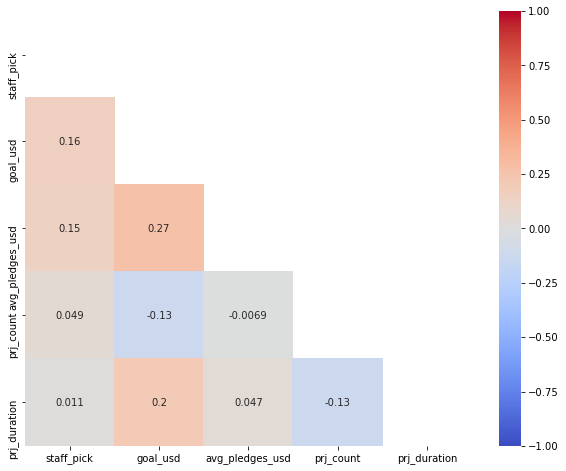

In [41]:
df_kickstarter_lean = copy.deepcopy(df_kickstarter[['category','country','staff_pick','goal_usd','avg_pledges_usd','prj_count','local_launched_date','prj_duration']])
cor_1 = df_kickstarter_lean.corr(method= 'spearman')

# https://stackoverflow.com/questions/57414771/how-to-plot-only-the-lower-triangle-of-a-seaborn-heatmap
mask = np.zeros_like(cor_1, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
fig = plt.figure(figsize =(10,8))
sns.heatmap(cor_1,mask=mask,vmin=-1, vmax=1,cmap='coolwarm',annot=True)

The correlation value shows that no attributes are correlate to each other

In [46]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 


# VIF dataframe 
vif_data = pd.DataFrame()
df_temp = df_kickstarter_lean[['staff_pick','goal_usd','avg_pledges_usd','prj_count','prj_duration']]
vif_data["feature"] = df_temp.columns
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(df_temp.values, i) 
                          for i in range(len(df_temp.columns))] 
  
print(vif_data)

           feature       VIF
0       staff_pick  1.168145
1         goal_usd  1.984424
2  avg_pledges_usd  2.471336
3        prj_count  1.297346
4     prj_duration  2.777784


No attributes shows a VIF above 5, which is generally a threshold for high muticollinearlity

<br> Fitting Logistic Regression

In [47]:
pred_col = ['category','country','goal_usd','avg_pledges_usd','prj_count','local_launched_date','prj_duration','staff_pick']
tar_val = ['state']

In [48]:
df_x = copy.deepcopy(df_kickstarter[pred_col])
#df_x['Intercept'] =1
df_y = copy.deepcopy(df_kickstarter[tar_val])

In [49]:
# Create one-hot coding variable

cont_pred = ['goal_usd','avg_pledges_usd','prj_count','prj_duration']
bool_pred = ['staff_pick','spotlight']
cat_pred = ['category','country','local_launched_date']

df_x = pd.get_dummies(df_x,columns = cat_pred)

In [51]:
#Split the data to train and test set
import sklearn.model_selection
from sklearn.linear_model import LogisticRegression
#Split to train and test and fit the result
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(df_x,df_y,train_size = 0.7,random_state = 0)

x_train =copy.deepcopy(x_train)
x_test = copy.deepcopy(x_test)




Standardize the features

In [52]:
#Standardize feautures to make the result easy to interpret
for i in cont_pred:
    x_train[i] = (x_train[i]-x_train[i].min())/(x_train[i].max()-x_train[i].min())
    x_test[i] = (x_test[i]-x_test[i].min())/(x_test[i].max()-x_test[i].min())

In [55]:
import statsmodels.api as sm
logit_mdl=sm.Logit(np.ravel(y_train),sm.add_constant(x_train)).fit()
print(logit_mdl.summary2())

Optimization terminated successfully.
         Current function value: 0.429671
         Iterations 9
                                       Results: Logit
Model:                       Logit                     Pseudo R-squared:          0.358      
Dependent Variable:          y                         AIC:                       119275.2479
Date:                        2020-12-20 16:05          BIC:                       119737.7274
No. Observations:            138689                    Log-Likelihood:            -59591.    
Df Model:                    46                        LL-Null:                   -92783.    
Df Residuals:                138642                    LLR p-value:               0.0000     
Converged:                   1.0000                    Scale:                     1.0000     
No. Iterations:              9.0000                                                          
--------------------------------------------------------------------------------------------

In [58]:
result1 = logit_mdl.summary2()

The result shows that ‘category’, ‘country’, and ‘local_launched_date’ attributes are not significant since the p-value is more than 0.05. 
While the most impactful attribute is prj_count, avg_pledges_usd and goal_usd respectively

## D.Validation of Results

Pseudo R2 and precision parameter are used to validate the model. Pseudo R2 is the parameter that indicates how well the model fits the training data. Precision is used to verify that the model is not overfitting.

In [68]:
#Calculate precisio value
from sklearn.metrics import classification_report

yprop1 =logit_mdl.predict(sm.add_constant(x_test))
ypred1 = list(map(round, yprop1)) 
print(classification_report(y_test, ypred1))

              precision    recall  f1-score   support

           0       0.81      0.72      0.76     23249
           1       0.83      0.89      0.86     36190

    accuracy                           0.82     59439
   macro avg       0.82      0.80      0.81     59439
weighted avg       0.82      0.82      0.82     59439



In [73]:
#Lookup the R2 Value
print('The model R2 value id is 0.358')
print('The model precision is 0.82')

The model R2 value id is 0.358
The model precision is 0.82


The number of pseudo R2 is in the range of 0.2 -0.4, which indicates that the model is well fitted. The precision against the test set is also around 80%. The results indicate that the model is appropriately fitted with the data and does not show the sign of overfitting.

The nan value in the constant term indicates that the model is not at the global minimum. Try to fitted the model again after removing non-significant variable to recheck the results

In [75]:
# Split the data into train and test set
pred_col_2 = ['goal_usd','avg_pledges_usd','prj_count','prj_duration','staff_pick']
df_x2 = copy.deepcopy(df_kickstarter[pred_col_2])
df_y2 = copy.deepcopy(df_kickstarter[tar_val])

x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(df_x2,df_y2,train_size = 0.7,random_state = 0)


x_train =copy.deepcopy(x_train)
x_test = copy.deepcopy(x_test)





In [76]:
#Standardize feautures
for i in cont_pred:
    x_train[i] = (x_train[i]-x_train[i].min())/(x_train[i].max()-x_train[i].min())
    x_test[i] = (x_test[i]-x_test[i].min())/(x_test[i].max()-x_test[i].min())

In [77]:
logit_mdl2=sm.Logit(np.ravel(y_train),sm.add_constant(x_train)).fit()
print(logit_mdl2.summary2())

Optimization terminated successfully.
         Current function value: 0.457654
         Iterations 8
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.316      
Dependent Variable: y                AIC:              126955.2844
Date:               2020-12-20 16:22 BIC:              127014.3243
No. Observations:   138689           Log-Likelihood:   -63472.    
Df Model:           5                LL-Null:          -92783.    
Df Residuals:       138683           LLR p-value:      0.0000     
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     8.0000                                        
------------------------------------------------------------------
                  Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
const            -0.4000   0.0211  -18.9917 0.0000 -0.4413 -0.3587
goal_usd         -4.4606   0.0417 -107.0061 0.0000 -4

The coefficient of each attribute is the same as previous model

In [78]:
#Calculate the new model precision.
yprop2 =logit_mdl2.predict(sm.add_constant(x_test))
ypred2 = list(map(round, yprop2))
print(classification_report(y_test, ypred2))


              precision    recall  f1-score   support

           0       0.80      0.71      0.75     23249
           1       0.83      0.89      0.86     36190

    accuracy                           0.82     59439
   macro avg       0.81      0.80      0.81     59439
weighted avg       0.82      0.82      0.82     59439



In [79]:
#Print parameter values for new model
print('The new model R2 value id is 0.316')
print('The new model precision is 0.81')

The new model R2 value id is 0.316
The new model precision is 0.81


After removing non-significant attribute, we can see that the new model fit properly. However, the model's coefficient , p-value , psedo R2 and precision is relatively the same as the in the first model. This also reconfirmed that we can trust the result of the first model


# END

The detailed finding of each outcome can be found in the paper